# LSTM

1. LSTMUnit
2. LSTMLayer
3. LSTM

In [1]:
# import relevant libraries
import numpy as np
import torch
import torch.nn as nn
import jax
import jax.numpy as jnp
import time
from tqdm import tqdm

**Terminologies**

* batch_size: B
* input_size: F
* hidden_size: U
* sequence_length: L

* input vector x: dimensions (B, F)
* hidden state vector v: dimesions (B, U)
* cell state vector c: dimesnions (B, U)

* input weight matrix W_ih: (F, 4U)
* hidden weight matrix W_hh: (U, 4U)
* bias weight vector: (1, 4U)

## Define Helper Functions

1. `sigmoid()`
2. `tanh()`
3. `LSTMUnit()`
4. `LSTMLayer()`
5. `LinearLayer()`
6. `LSTMModel()`
7. `loss()`
8. `grad`
9. `update()`

In [2]:
# define sigmoid function
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

# define tanh function
def tanh(x):
    return jnp.tanh(x)

In [3]:
# define LSTM Unit
def LSTMUnit(params, x, h, c):
    """
    Inputs
    params: list of parameters, [W_ih, W_hh, b]
    x: input, dim = (B, F)
    h: hidden state, dim = (B, U)
    c: cell state, dim = (B, U)

    Outputs
    h_next: next hidden state, dim = (B, U)
    c_next: next cell state, dim = (B, U)
    """
    W_ih = params[0] # dim = (F, 4U)
    W_hh = params[1] # dim = (U, 4U)
    b = params[2] # dim = (1, 4U)

    # generate inputs to all the gates
    gates_input = x @ W_ih + h @ W_hh + b # dim = (B, 4U)

    # split the input to the gates
    i, f, g, o = np.split(gates_input, 4, axis=1) # dim = (B, U)

    # apply activation functions
    i = sigmoid(i)
    f = sigmoid(f)
    g = tanh(g)
    o = sigmoid(o)

    # update the cell and hidden state
    c_next = f * c + i * g
    h_next = o * tanh(c_next)

    return h_next, c_next

In [4]:
def LSTMLayer(params, X, h, c):
    """
    Inputs
    params: list of parameters, [W_ih, W_hh, b]
    X: input, dim = (L, B, F)
    h: hidden state, dim = (B, U)
    c: cell state, dim = (B, U)

    Outputs
    H: hidden states, dim = (L, B, U)
    (hn, cn): last hidden and cell states, dim = ( (B, U), (B, U) ) --> optional
    """
    H = jnp.zeros((X.shape[0], X.shape[1], h.shape[1])) # dim = (L, B, U)
    for t in range(X.shape[0]):
        h, c = LSTMUnit(params, X[t], h, c)
        # use update H with jax.numpy
        H = H.at[t].set(h)
        # H[t] = h
    # return H, (h, c)
    return H

In [5]:
# define model
sequence_length = 5
batch_size = 2
input_size = 3
hidden_size = 6

model = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)

# check weights of the model
for name, param in model.named_parameters():
    print(name, param.shape)

weight_ih_l0 torch.Size([24, 3])
weight_hh_l0 torch.Size([24, 6])
bias_ih_l0 torch.Size([24])
bias_hh_l0 torch.Size([24])


In [6]:
# extract weights from the model
W_ih = model.weight_ih_l0.detach().numpy().T
W_hh = model.weight_hh_l0.detach().numpy().T
b = model.bias_ih_l0.detach().numpy().T + model.bias_hh_l0.detach().numpy().T

# print shapes of the parameters
print(W_ih.shape)
print(W_hh.shape)
print(b.shape)

(3, 24)
(6, 24)
(24,)


In [7]:
# test the model vs the custom implementation
# generate random data first
X = np.random.randn(sequence_length, batch_size, input_size).astype(np.float32)
h0 = np.random.randn(1, batch_size, hidden_size).astype(np.float32)
c0 = np.random.randn(1, batch_size, hidden_size).astype(np.float32)

# run the custom model
# H, (hn, cn) = LSTMLayer([W_ih, W_hh, b], X, h0[0], c0[0])
H = LSTMLayer([W_ih, W_hh, b], X, h0[0], c0[0])

# run the pytorch model
# X_torch is dimensions (L, B, F), but the model expects (B, L, F)
X_torch = torch.tensor(X.transpose(1, 0, 2))
h0_torch = torch.tensor(h0)
c0_torch = torch.tensor(c0)
H_torch, (hn_torch, cn_torch) = model(X_torch, (h0_torch, c0_torch))

# print difference in shape
print(f'H shape: {H.shape}, H_torch shape: {H_torch.shape}')
# print(f'hn shape: {hn.shape}, hn_torch shape: {hn_torch.shape}')
# print(f'cn shape: {cn.shape}, cn_torch shape: {cn_torch.shape}\n')
print(f'Difference between H, H_torch: {np.linalg.norm(H.transpose(1, 0, 2) - H_torch.detach().numpy())}')
# print(f'Difference between hn, hn_torch: {np.linalg.norm(hn - hn_torch.detach().numpy())}')
# print(f'Difference between cn, cn_torch: {np.linalg.norm(cn - cn_torch.detach().numpy())}')

H shape: (5, 2, 6), H_torch shape: torch.Size([2, 5, 6])
Difference between H, H_torch: 2.227594393389154e-07


In [8]:
# define linear model
def LinearLayer(params, H):
    """
    Inputs
    params = [W_out, b_out], where W_out --> dim (U, 0), b_out --> dim (1, 0)
    H: hidden states, dim = (L, B, U)

    Output
    y_out: output vector, dim = (B, O), where O is the output size
    """
    W_out = params[0] # dim = (U, O)
    b_out = params[1] # dim = (1, O)

    # reshape the hidden states (L, B, U) -> (L*B, U)
    H_reshaped = H.reshape(-1, H.shape[2]); # print(f'H_reshaped shape: {H_reshaped.shape}') # dim = (L*B, U)

    # calculate the output
    y_out = jnp.dot(H_reshaped, W_out) + b_out # dim = (L*B, O)
    
    # reshape to dim = (L, B, O)
    y_out_reshaped = y_out.reshape(H.shape[0], H.shape[1], W_out.shape[1]) # print(f'y_out shape: {y_out.shape}') # dim = (L, B, O)
    return y_out_reshaped

In [9]:
# combine the LSTMLayer and LinearLayer
def LSTMModel(params, X, h0, c0):
    """
    Inputs
    params = [W_ih, W_hh, b, W_out, b_out]
    X: input, dim = (L, B, F)
    h0: initial hidden state, dim = (B, U)
    c0: initial cell state, dim = (B, U)

    Output
    y_out: output vector, dim = (B, O), where O is the output size
    """
    W_ih = params[0]
    W_hh = params[1]
    b = params[2]
    W_out = params[3]
    b_out = params[4]

    # H, (hn, cn) = LSTMLayer([W_ih, W_hh, b], X, h0, c0)
    H = LSTMLayer([W_ih, W_hh, b], X, h0, c0)
    y_out = LinearLayer([W_out, b_out], H)

    return y_out # dim = (L, B, O)

In [ ]:
y = np.random.randn(2,3,4).astype(np.float32)
y_hat = np.random.rand(2,3,4).astype(np.float32)

jnp.mean((y-y_hat)**2)

In [10]:
# create loss function
@jax.jit
def loss(params, X, y, h0, c0):
    """
    Inputs
    params = [W_ih, W_hh, b, W_out, b_out]
    X = batch of inputs -> (L, B, F)
    y = batch of true labels -> (L, B, O)
    h0 = initial hidden state -> (B, U)
    c0 = initial cell state -> (B, U)
    """
    # y_pred -> dim = (L, B, O)
    y_pred = LSTMModel(params, X, h0, c0)
    # y -> dim = (L, B, O)
    # given that the loss function is MSE
    return jnp.mean((y - y_pred) ** 2)
    
# create gradient function
grad = jax.grad(loss)

@jax.jit
def update(params, X, y, h0, c0):
    grads = grad(params, X, y, h0, c0)
    return [w - lr * dw for w, dw in zip(params, grads)]

In [11]:
# test the model
# generate random data first
sequence_length = 12 # L
batch_size = 10 # B
input_size = 1 # F
hidden_size = 5 # U
output_size = 1 # O
lr = 0.01

X = np.random.randn(sequence_length, batch_size, input_size).astype(np.float32) # dim = (L, B, F)
h0 = np.random.randn(batch_size, hidden_size).astype(np.float32) # dim = (B, U)
c0 = np.random.randn(batch_size, hidden_size).astype(np.float32) # dim = (B, U)

# generate random parameters
W_ih = np.random.randn(input_size, 4*hidden_size).astype(np.float32) # dim = (F, 4U)
W_hh = np.random.randn(hidden_size, 4*hidden_size).astype(np.float32) # dim = (U, 4U)
b = np.random.randn(1, 4*hidden_size).astype(np.float32) # dim = (1, 4U)
W_out = np.random.randn(hidden_size, output_size).astype(np.float32) # dim = (U, O)
b_out = np.random.randn(1, output_size).astype(np.float32) # dim = (1, O)

# run the custom model
y_out = LSTMModel([W_ih, W_hh, b, W_out, b_out], X, h0, c0) # dim = (L, B, O)
# print the output
print(f'y_out shape: {y_out.shape}')

# test the loss function
# generate random data first
# t_X will be of shape (B, L*F), but need convert to (L, B, F)
t_X = np.random.randn(batch_size, sequence_length*input_size).astype(np.float32) # dim = (B, L*F)
convert_t_x = t_X.reshape(sequence_length, batch_size, input_size) # dim = (L, B, F)
# similarly for t_y need to convert from (B, L*O) to (L*B, O)
t_y = np.random.randn(batch_size, sequence_length*output_size).astype(np.float32) # dim = (B, L*O)
convert_t_y = t_y.reshape(sequence_length, batch_size, output_size) # dim = (L, B, O)

# print shapes of W_ih, W_hh, b, W_out, b_out, convert_t_x, convert_t_y, h0, c0
print("+++++++++++++++++++++++++++++++++++")
print(f'W_ih shape: {W_ih.shape} \t W_ih type: {type(W_ih)}')
print(f'W_hh shape: {W_hh.shape} \t W_hh type: {type(W_hh)}')
print(f'b shape: {b.shape} \t b type: {type(b)}')
print(f'W_out shape: {W_out.shape} \t W_out type: {type(W_out)}')
print(f'b_out shape: {b_out.shape} \t b_out type: {type(b_out)}')
print(f'convert_t_x shape: {convert_t_x.shape} \t convert_t_x type: {type(convert_t_x)}')
print(f'convert_t_y shape: {convert_t_y.shape} \t convert_t_y type: {type(convert_t_y)}')
print(f'h0 shape: {h0.shape} \t h0 type: {type(h0)}')
print(f'c0 shape: {c0.shape} \t c0 type: {type(c0)}')
print("+++++++++++++++++++++++++++++++++++")

# run the loss function
losses = loss([W_ih, W_hh, b, W_out, b_out], convert_t_x, convert_t_y, h0, c0)
print(f'loss: {losses}')

# test the update function
params = [W_ih, W_hh, b, W_out, b_out]
params = update(params, convert_t_x, convert_t_y, h0, c0)

# print shape of updated params
for param in params:
    print(param.shape)

y_out shape: (12, 10, 1)
+++++++++++++++++++++++++++++++++++
W_ih shape: (1, 20) 	 W_ih type: <class 'numpy.ndarray'>
W_hh shape: (5, 20) 	 W_hh type: <class 'numpy.ndarray'>
b shape: (1, 20) 	 b type: <class 'numpy.ndarray'>
W_out shape: (5, 1) 	 W_out type: <class 'numpy.ndarray'>
b_out shape: (1, 1) 	 b_out type: <class 'numpy.ndarray'>
convert_t_x shape: (12, 10, 1) 	 convert_t_x type: <class 'numpy.ndarray'>
convert_t_y shape: (12, 10, 1) 	 convert_t_y type: <class 'numpy.ndarray'>
h0 shape: (10, 5) 	 h0 type: <class 'numpy.ndarray'>
c0 shape: (10, 5) 	 c0 type: <class 'numpy.ndarray'>
+++++++++++++++++++++++++++++++++++
loss: 2.6284384727478027
(1, 20)
(5, 20)
(1, 20)
(5, 1)
(1, 1)


## Model

### Read Data

In [12]:
# import data
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# read data
data = pd.read_csv('./data/raw/GlobalTemperatures.csv')

print(data.shape)
data.head()

(3192, 9)


,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


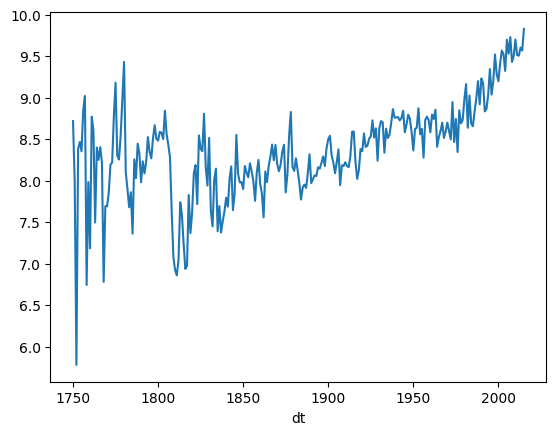

In [14]:
# convert dt column to datetime
data['dt'] = pd.to_datetime(data['dt'])

# plot the data['LandAverageTemperature], group by year
data.groupby(data['dt'].dt.year)['LandAverageTemperature'].mean().plot()
plt.show()

### Data Cleaning

1. Data from `1800-01-01` (inclusive) to `2015-12-01` (inclusive)
2. Train data from `1800-01-01` to `1999-12-01`
    * Training set from `1800-01-01` to `1959-12-01`
    * Validation set from `1960-01-01` to `1999-12-01`
3. Test data from `2000-01-01` to `2015-12-01`

In [15]:
# convert dt column from str to datetime
data['dt'] = pd.to_datetime(data['dt'])

# keep first 2 columns
data = data.iloc[:, :2]

# split into train, validation and test sets
train_data = data[(data['dt'] >= '1800-01-01') & (data['dt'] < '1960-01-01')]
validation_data = data[(data['dt'] >= '1960-01-01') & (data['dt'] < '2000-01-01')]
test_data = data[(data['dt'] >= '2000-01-01')] 

# check shapes, check first and last column of each set
print(f'train_data shape: {train_data.shape}')
# print(f'train_data first row: {train_data.iloc[0, :]}')
# print(f'train_data last row: {train_data.iloc[-1, :]}\n')

print(f'validation_data shape: {validation_data.shape}')
# print(f'validation_data first row: {validation_data.iloc[0, :]}')
# print(f'validation_data last row: {validation_data.iloc[-1, :]}\n')

print(f'test_data shape: {test_data.shape}')
# print(f'test_data first row: {test_data.iloc[0, :]}')
# print(f'test_data last row: {test_data.iloc[-1, :]}\n')

train_data shape: (1920, 2)
validation_data shape: (480, 2)
test_data shape: (192, 2)


In [16]:
# generate sequences
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset.iloc[i:i+lookback, 1]
        target = dataset.iloc[i+1:i+lookback+1, 1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

In [17]:
# generate sequences
def create_validation_test_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset.iloc[i:i+lookback, 1]
        target = dataset.iloc[i+lookback, 1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

In [137]:
train_X, train_y = create_dataset(train_data, 12)

# print shape
print(f'train_X shape: {train_X.shape}')
print(f'train_y shape: {train_y.shape}')

train_X shape: (1908, 12)
train_y shape: (1908, 12)


In [138]:
validate_X, validate_y = create_dataset(validation_data, 12)

# print shape
print(f'validate_X shape: {validate_X.shape}')
print(f'validate_y shape: {validate_y.shape}')

validate_X shape: (468, 12)
validate_y shape: (468, 12)


In [139]:
test_X, test_y = create_dataset(test_data, 12)

# print shape
print(f'test_X shape: {test_X.shape}')
print(f'test_y shape: {test_y.shape}')

test_X shape: (180, 12)
test_y shape: (180, 12)


In [140]:
train_X[0].shape

(12,)

### Set Up LSTM Parameters

In [141]:
# convert train_X from (N, L*F) to (N, L, F) and train_y from (N, L*O) to (N, L, O) to respectively
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], output_size)
train_y = train_y.reshape(train_y.shape[0], train_y.shape[1], output_size)

# convert validate_X from (N, L*F) to (N, L, F) and validate_y from (N, L*O) to (N, L, O) to respectively
validate_X = validate_X.reshape(validate_X.shape[0], validate_X.shape[1], output_size)
validate_y = validate_y.reshape(validate_y.shape[0], validate_y.shape[1], output_size)

# convert test_X from (N, L*F) to (N, L, F) and test_y from (N, L*O) to (N, L, O) to respectively
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], output_size)
test_y = test_y.reshape(test_y.shape[0], test_y.shape[1], output_size)

# drop last 8 rows of train_X and train_y
train_X = train_X[:-8]
train_y = train_y[:-8]

# drop last 8 rows of validate_X and validate_y
validate_X = validate_X[:-8]
validate_y = validate_y[:-8]

# print shapes
print(f'train_X shape: {train_X.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'validate_X shape: {validate_X.shape}')
print(f'validate_y shape: {validate_y.shape}')
print(f'test_X shape: {test_X.shape}')
print(f'test_y shape: {test_y.shape}')

train_X shape: (1900, 12, 1)
train_y shape: (1900, 12, 1)
validate_X shape: (460, 12, 1)
validate_y shape: (460, 12, 1)
test_X shape: (180, 12, 1)
test_y shape: (180, 12, 1)


In [142]:
# parameters
N = train_X.shape[0]
batch_size = 20 # B
input_size = 1 # F
hidden_size = 5 # U
sequence_length = 12 # L
output_size = 1 # O

# generate weights from LSTM model
model = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
W_ih = model.weight_ih_l0.detach().numpy().T
W_hh = model.weight_hh_l0.detach().numpy().T
b = model.bias_ih_l0.detach().numpy().T + model.bias_hh_l0.detach().numpy().T
#W_ih = np.random.normal(0, 1, size=(input_size, 4*hidden_size)) # dim = (F, 4U)
#W_hh = np.random.normal(0, 1, size=(hidden_size, 4*hidden_size)) # dim = (U, 4U)
#b = np.random.normal(0, 1, size=(1, 4*hidden_size)) # dim = (1, 4U)

# generate weights for the output layer
W_out = np.random.normal(0, 1, size=(hidden_size, output_size)) # dim = (U, O)
b_out = np.random.normal(0, 1, size=(1, output_size)) # dim = (1, O)

# initial hidden and cell states and params
h0_init = np.random.randn(batch_size, hidden_size).astype(np.float32) # dim = (B, U)
c0_init = np.random.randn(batch_size, hidden_size).astype(np.float32) # dim = (B, U)
params_init = [W_ih, W_hh, b, W_out, b_out]

# print all the shapes
print(f'W_ih shape: {W_ih.shape}')
print(f'W_hh shape: {W_hh.shape}')
print(f'b shape: {b.shape}')
print(f'W_out shape: {W_out.shape}')
print(f'b_out shape: {b_out.shape}')
print(f'h0_init shape: {h0_init.shape}')
print(f'c0_init shape: {c0_init.shape}')

W_ih shape: (1, 20)
W_hh shape: (5, 20)
b shape: (20,)
W_out shape: (5, 1)
b_out shape: (1, 1)
h0_init shape: (20, 5)
c0_init shape: (20, 5)


### Model Training

#### Gradient Descent

In [143]:
# perform training
lr = 0.001
n_epochs = 1000
n_batches = N // batch_size


# store losses
epoch_losses = []
validation_losses = []
test_losses = []

# initial hidden and cell states
params = params_init.copy()
h0 = h0_init.copy()
c0 = c0_init.copy()

# train the model
for epoch in range(n_epochs):
    # start time
    start = time.time()

    if epoch % 250 == 0:
        lr = lr / 4

    losses = []
    for i in range(n_batches):
        # extract the batch of train_X and train_y
        # note that train_X dim = (N, L, F) and train_y dim = (N, L, O)
        # so we need to extract the batch of train_X and train_y
        batch_X = train_X[i*batch_size:(i+1)*batch_size] # dim = (B, L, F)
        batch_y = train_y[i*batch_size:(i+1)*batch_size] # dim = (B, L, O)

        # extract input and output from train_X and train_y
        # batch_X dim = (B, L, F) --> (L, B, F)
        # batch_y dim = (B, L, 0) --> (L, B, O)
        batch_X_reshaped = batch_X.transpose(1, 0, 2)
        batch_y_reshaped = batch_y.transpose(1, 0, 2)

        # calculate the loss
        loss_val = loss(params, batch_X_reshaped, batch_y_reshaped, h0, c0)
        losses.append(loss_val)

        # update the parameters
        params = update(params, batch_X_reshaped, batch_y_reshaped, h0, c0)

    # select a random subset, validation_X_reshaped_batch that is the same size as batch_size
    # select n random indices within the range of validation_X
    indices = np.random.choice(range(len(validate_X)), batch_size)
    # select the random indices from validation_X and validation_y
    validation_X_batch = validate_X[indices]
    validation_y_batch = validate_y[indices]

    # select a random subset, test_X_reshaped_batch that is the same size as batch_size
    # select n random indices within the range of test_X
    indices = np.random.choice(range(len(test_X)), batch_size)
    # select the random indices from test_X and test_y
    test_X_batch = test_X[indices]
    test_y_batch = test_y[indices]

    # reshape validation and test sets
    validation_X_reshaped_batch = validation_X_batch.transpose(1, 0, 2); #print(f'validation_X_reshaped_batch shape: {validation_X_reshaped_batch.shape}')
    validation_y_reshaped_batch = validation_y_batch.transpose(1, 0, 2); #print(f'validation_y_reshaped_batch shape: {validation_y_reshaped_batch.shape}')
    test_X_reshaped_batch = test_X_batch.transpose(1, 0, 2); #print(f'test_X_reshaped_batch shape: {test_X_reshaped_batch.shape}')
    test_y_reshaped_batch = test_y_batch.transpose(1, 0, 2); #print(f'test_y_reshaped_batch shape: {test_y_reshaped_batch.shape}')

    # calculate losses
    validation_loss = loss(params, validation_X_reshaped_batch, validation_y_reshaped_batch, h0, c0)
    test_loss = loss(params, test_X_reshaped_batch, test_y_reshaped_batch, h0, c0)

    # store losses
    epoch_losses.append(np.mean(losses))
    validation_losses.append(validation_loss)
    test_losses.append(test_loss)

    # end timing
    end = time.time()

    # print the loss and time taken
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} \t loss = {np.mean(epoch_losses)} \t time = {end - start:.2f}s")

Epoch 1/1000 	 loss = 67.67881774902344 	 time = 0.07s
Epoch 101/1000 	 loss = 3.6146552562713623 	 time = 0.06s
Epoch 201/1000 	 loss = 2.4572722911834717 	 time = 0.06s
Epoch 301/1000 	 loss = 2.036397933959961 	 time = 0.07s
Epoch 401/1000 	 loss = 1.8111339807510376 	 time = 0.06s
Epoch 501/1000 	 loss = 1.6662111282348633 	 time = 0.06s
Epoch 601/1000 	 loss = 1.5636826753616333 	 time = 0.06s
Epoch 701/1000 	 loss = 1.487123966217041 	 time = 0.06s
Epoch 801/1000 	 loss = 1.4276713132858276 	 time = 0.06s
Epoch 901/1000 	 loss = 1.3800277709960938 	 time = 0.06s


In [144]:
# print all the last MSE values
print(f'train MSE: {epoch_losses[-1]}')
print(f'validation MSE: {validation_losses[-1]}')
print(f'test MSE: {test_losses[-1]}')

train MSE: 0.9831333160400391
validation MSE: 0.8756228089332581
test MSE: 1.2025924921035767


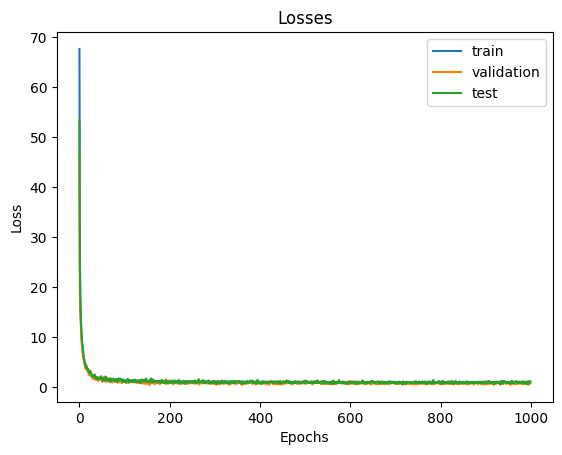

In [145]:
# plot epoch_losses, validation_losses and test_losses
# epoch_losses in blue, validation_losses in green and test_losses in red
# add title, xlabel and ylabel
plt.plot(epoch_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.plot(test_losses, label='test')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


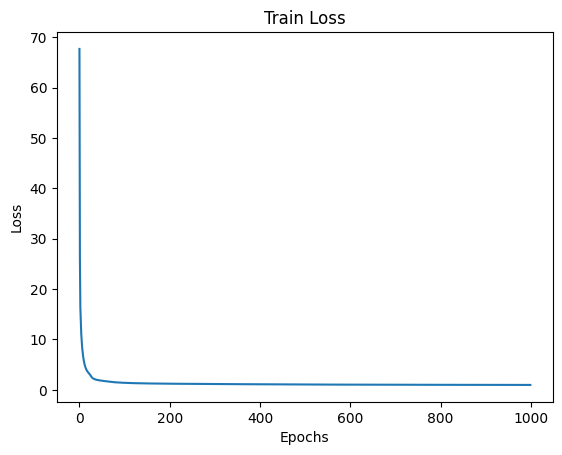

In [146]:
# plot epoch_losses
plt.plot(epoch_losses)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

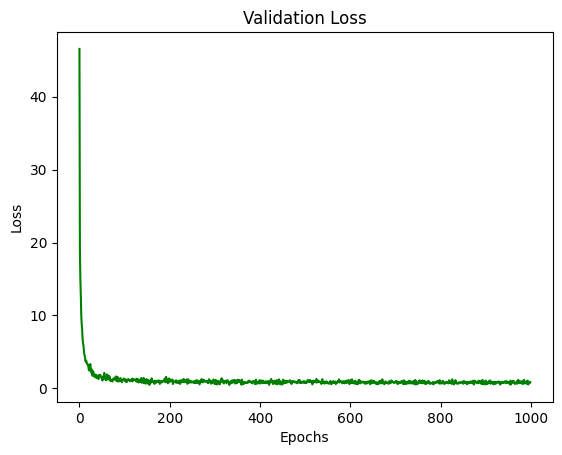

In [147]:
# plot validation loss, green color
plt.plot(validation_losses, color='green')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

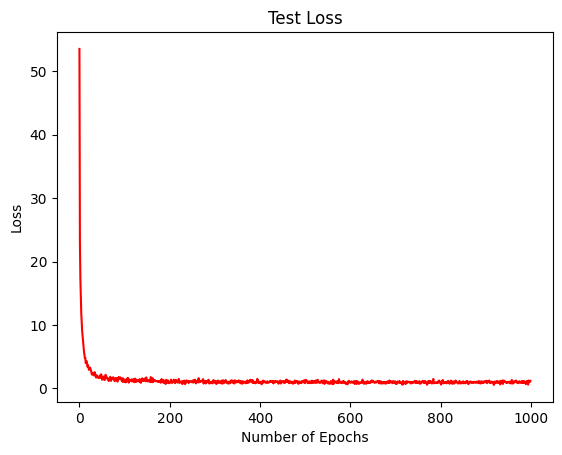

In [148]:
# plot test loss, red color
plt.plot(test_losses, color='red')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show()

In [149]:
# given the trained model, updated weights and biases, calculate the predictions
# input is the trained model, updated weights and biases, test_X, h0 and c0, test_X dim = (N, L, F)
# output is the predictions, test_y dim = (N, L, O)
# divide the input into batches of batch_size, in each batch, calculate the predictions, y_pred dim = (L, B, O)
# reshape y_pred from (L, B, O) to (B, L, O), for each b in B, the dim = (L,O), take the last row, i.e. the prediction shape should be (1, O),
# y_predictions
# break test_X into batches of batch_size
y_predictions = []
for batch in range(0, len(test_X), batch_size):
    # extract the batch of test_X
    test_X_batch = test_X[batch:batch+batch_size] # dim = (B, L, F)
    # reshape test_X_batch
    test_X_reshaped_batch = test_X_batch.transpose(1, 0, 2) # dim = (L, B, F)
    # calculate the predictions
    y_pred = LSTMModel(params, test_X_reshaped_batch, h0, c0) # dim = (L, B, O)
    # reshape y_pred from (L, B, O) to (B, L, O)
    y_pred_reshaped = y_pred.transpose(1, 0, 2) # dim = (B, L, O)
    # for each b in B, take the last row, i.e. the prediction shape should be (1, O)
    for b in range(y_pred_reshaped.shape[0]):
        # extract the prediction
        prediction = y_pred_reshaped[b][-1] # dim = (1, O)
        # extract the true value
        true_value = test_y[batch+b][-1] # dim = (1, O)
        # append to y_predictions
        y_predictions.append(prediction)

# convert y_predictions to numpy array
y_predictions = np.array(y_predictions)

# print the shape of y_predictions
print(f'y_predictions shape: {y_predictions.shape}')

y_predictions shape: (180, 1)


/var/folders/_3/8z9s_23x6w349w1_9vlqlhzh0000gn/T/ipykernel_85033/1511840881.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df['predictions'] = y_predictions[:-1]


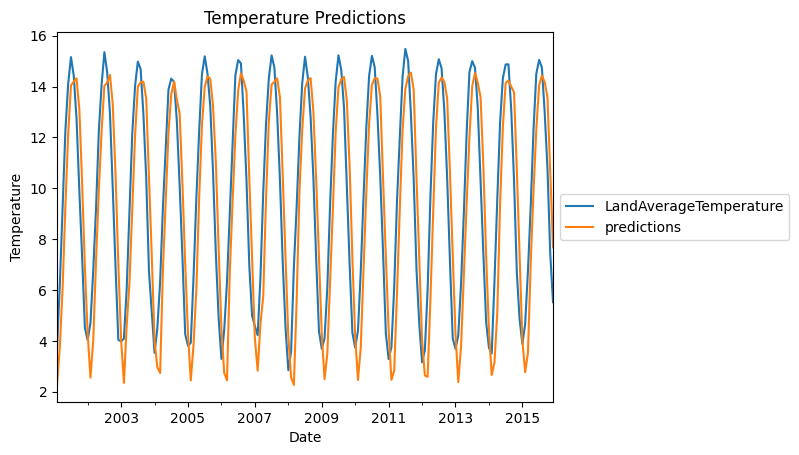

In [150]:
# extract the last 180-1 rows from data
y_df = data.iloc[-179:]

# append the y_predictions[:-1] to y_df
y_df['predictions'] = y_predictions[:-1]

# plot the data, label axes, put legend outside the plot
y_df.plot(x='dt', y=['LandAverageTemperature', 'predictions'])
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Temperature Predictions')
plt.show()

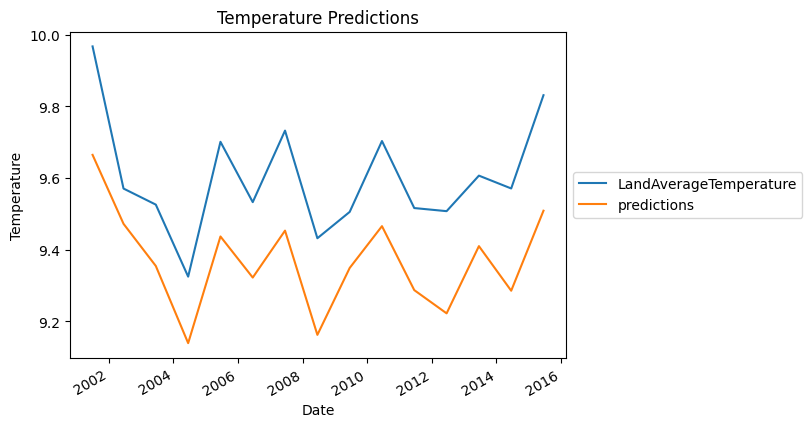

In [151]:
# plot the data, label axes, put legend outside the plot, group by year
y_df.groupby(y_df['dt'].dt.year).mean().plot(x='dt', y=['LandAverageTemperature', 'predictions'])
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Temperature Predictions')
plt.show()

In [152]:
# given the trained model, updated weights and biases, calculate the predictions
# input is the trained model, updated weights and biases, test_X, h0 and c0, test_X dim = (N, L, F)
# output is the predictions, test_y dim = (N, L, O)
# divide the input into batches of batch_size, in each batch, calculate the predictions, y_pred dim = (L, B, O)
# reshape y_pred from (L, B, O) to (B, L, O), for each b in B, the dim = (L,O), take the last row, i.e. the prediction shape should be (1, O),
# y_predictions
# break test_X into batches of batch_size
validation_test_X = np.concatenate((validate_X, test_X), axis=0)
validation_test_y = np.concatenate((validate_y, test_y), axis=0)
y_predictions = []
for batch in range(0, len(validation_test_X), batch_size):
    # extract the batch of test_X
    test_X_batch = validation_test_X[batch:batch+batch_size] # dim = (B, L, F)
    # reshape test_X_batch
    test_X_reshaped_batch = test_X_batch.transpose(1, 0, 2) # dim = (L, B, F)
    # calculate the predictions
    y_pred = LSTMModel(params, test_X_reshaped_batch, h0, c0) # dim = (L, B, O)
    # reshape y_pred from (L, B, O) to (B, L, O)
    y_pred_reshaped = y_pred.transpose(1, 0, 2) # dim = (B, L, O)
    # for each b in B, take the last row, i.e. the prediction shape should be (1, O)
    for b in range(y_pred_reshaped.shape[0]):
        # extract the prediction
        prediction = y_pred_reshaped[b][-1] # dim = (1, O)
        # extract the true value
        true_value = validation_test_y[batch+b][-1] # dim = (1, O)
        # append to y_predictions
        y_predictions.append(prediction)

# convert y_predictions to numpy array
y_predictions = np.array(y_predictions)

# print the shape of y_predictions
print(f'y_predictions shape: {y_predictions.shape}')

y_predictions shape: (640, 1)


/var/folders/_3/8z9s_23x6w349w1_9vlqlhzh0000gn/T/ipykernel_85033/956803422.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df['predictions'] = y_predictions[:-1]


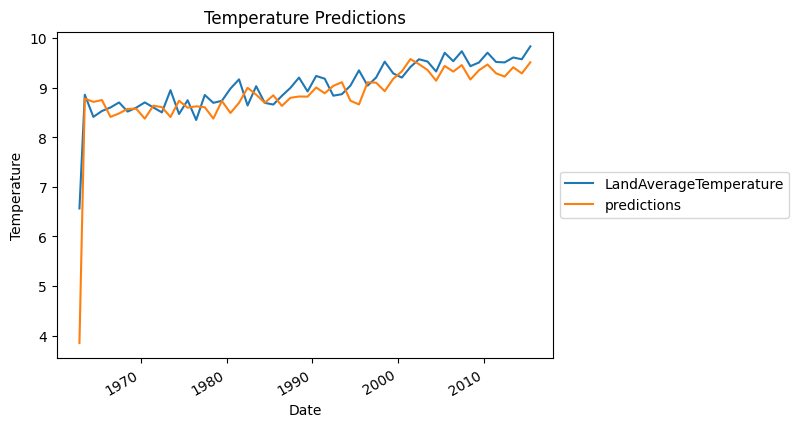

In [153]:
# extract the last 180-1 rows from data
y_df = data.iloc[-639:]

# append the y_predictions[:-1] to y_df
y_df['predictions'] = y_predictions[:-1]

# plot the data, label axes, put legend outside the plot, group by year
y_df.groupby(y_df['dt'].dt.year).mean().plot(x='dt', y=['LandAverageTemperature', 'predictions'])
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Temperature Predictions')
plt.show()